# qs to yosh
    
    0. script and not notebook ?
    1. no eda ?
    2. this is my understanding of what to do what do you think


TODO : plot learning progression, hyper opt, calculate rmse on test, feature importance,

# plan of action
    1. examine differences between train and test in terms of dates and label distribution
    1. examine features distribution, nan, is there anything wierd in the data?
    2. compare distributions of train and test use kl divergence to elevate largest diffs
    
    2. examine relationships between features and label
    3. train and compare xgb,cat,lgb using only train and cv. > understand whether to split by time and or another column
    4. research gaming data in kaggle look for cool stuff
    5. wrap all in script

In [6]:

import pandas as pd
import numpy as np

import xgboost as xgb

import catboost as cat

import lightgbm as lgb

import matplotlib.pyplot as plt

from typing import List, Dict, Optional, NamedTuple


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import operator


import shap

# settings

In [19]:

DESTINATION_PATH = r"C:\Users\amirm\Documents\moon\home_assignment"

training_data_path = r"C:\Users\amirm\Documents\moon\home_assignment\train_home_assignment.csv"
test_data_path = r"C:\Users\amirm\Documents\moon\home_assignment\test_home_assignment.csv"



train = pd.read_csv(training_data_path)
test = pd.read_csv(test_data_path)


In [41]:
TARGET_COL = 'org_price_usd_following_30_days'

XGB_PARAMS = {"objective" :'reg:squarederror',
                             "colsample_bytree":0.8,
                            "learning_rate":0.03,
                             "max_depth":4,
                             "subsample":1,
                             "seed":42,
                             'eval_metric': 'rmse'
                             #'base_score': 0.2,
                             #'alpha':5
                                 }

# data distribtuion examination

In [21]:
print("train has {} null values".format(train.isna().sum().sum()))

train has 0 null values


In [22]:
def compare_train_test_distributions(train : pd.DataFrame, test : pd.DataFrame) -> List[str]:

    '''
    
    this function will compare the average of the features between train and test,
    and return the top10 most different mean features
    
    '''
    

    temp = train_filtered.mean().reset_index()

    temp.columns = ["train_col",'train_mean']


    temp_test = test.mean().reset_index()

    temp_test.columns = ["test_col",'test_mean']


    merged = temp.merge(temp_test,left_on = ['train_col'], right_on = ['test_col'])

    merged["mean_ratio"] = (merged["test_mean"] - merged["train_mean"]).abs() /merged["test_mean"]


    #merged.sort_values('mean_ratio', ascending=False).head(10)

    features_to_remove = merged.sort_values('mean_ratio', ascending=False).head(10)["train_col"].tolist()
    
    return features_to_remove


features_to_remove = compare_train_test_distributions(train, test)

### label max

In [23]:
print(train.shape)

train_filtered = train[train[TARGET_COL]<=test[TARGET_COL].max()]

print(train_filtered.shape)

(200000, 54)
(199997, 54)


### weekday

In [24]:
print(train_filtered.shape)
train_filtered = train_filtered[train_filtered["weekday"].isin(test["weekday"].unique())]
print(train_filtered.shape)

(199997, 54)
(52798, 54)


### remove 10 un alligned features

In [25]:
print(train_filtered.shape)
train_filtered = train_filtered[train_filtered.columns.difference(features_to_remove)]
print(train_filtered.shape)

(52798, 54)
(52798, 44)


# modelling classes and functions

In [31]:
# customize data objects
class SplitedData(NamedTuple):
    
    
    train: Dict[str, pd.DataFrame]
    test: Dict[str, pd.DataFrame]
    val: Dict[str, pd.DataFrame]
        

class ModelArtifacts(NamedTuple):
    
    
    xgb_estimator: xgb.core.Booster
        
    splited_data: SplitedData
    features: List[str]
    
    preds_train : List[float]
    preds_val : List[float]
    preds_test : List[float]
   
    
    


In [36]:
def split_data(all_training_data: pd.DataFrame, label_col = TARGET_COL, test = test) -> SplitedData:

    '''
    splits the training data to trainand val randomly
    '''
    
    features = all_training_data.columns.difference([label_col]).tolist()
    
    X_train, X_val, y_train, y_val = train_test_split(all_training_data[features], all_training_data[label_col], test_size=0.1, random_state=42)
    
    
    return SplitedData(
        train = {'X': X_train, 'y': y_train},
        val = {'X': X_val, 'y': y_val},
        test = {'X': test[features], 'y': test[label_col]}
        
    ) 


In [45]:
def importance(model,importance_type='gain',write=False,path=""):
    
    '''
    
    plots feature importnace of xgb model
    
    '''

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca()
    xgb.plot_importance(model, max_num_features=30, height=0.8, ax=ax,importance_type=importance_type)
    if write:
        
       plt.savefig('{}/importance.png'.format(path))
    
    
    
def plot_importance_and_shaps(ModelArtifacts):
    
    '''
    
    plots feature importance, summary shap, and shap interaction of top feature
    
    '''
    
    
    importance(ModelArtifacts.xgb_estimator)
    plt.show()

    shap_values = shap.TreeExplainer(ModelArtifacts.xgb_estimator).shap_values(ModelArtifacts.splited_data.val['X'])
    # plot summary plot
    shap.summary_plot(shap_values, ModelArtifacts.splited_data.val['X'])
    plt.show()
    

    imp_dict = ModelArtifacts.xgb_estimator.get_score(importance_type='gain')

    top_feature_by_gain = max(imp_dict.items(), key=operator.itemgetter(1))[0]

    # plot interaction of top feature
    shap.dependence_plot(top_feature_by_gain, shap_values, ModelArtifacts.splited_data.val['X'])
    plt.show()

    

In [42]:
def train_xgb_model(all_training_data: pd.DataFrame, params = XGB_PARAMS) -> ModelArtifacts:
    
    
    num_round=1000
    progress={}

    
    # split training data
    training_data_splitted = split_data(all_training_data)

    
    # train xgb
    dtrain = xgb.DMatrix(training_data_splitted.train['X'], label=training_data_splitted.train['y'])
    dval = xgb.DMatrix(training_data_splitted.val['X'], label=training_data_splitted.val['y'])
    dtest = xgb.DMatrix(training_data_splitted.test['X'], label=training_data_splitted.test['y'])

    watchlist=[(dtrain,'train'),(dval,'val')]

    bst = xgb.train(params, dtrain,num_round,evals=watchlist,early_stopping_rounds=5,evals_result=progress)


    # predict
    preds_val = bst.predict(dval)
    preds_train = bst.predict(dtrain)
    preds_test = bst.predict(dtest)
    
    
    # plot rmse progress by iteration
    plt.plot([i for i in range(len(progress["train"][params["eval_metric"]]))],progress["train"][params["eval_metric"]],label="train")
    plt.plot([i for i in range(len(progress["train"][params["eval_metric"]]))],progress["val"][params["eval_metric"]],label="val")

    plt.xlabel('iteration')
    plt.ylabel(params["eval_metric"])
    plt.title('xgb rmse by iteration')
    plt.legend()
    plt.show()
    
    
    return ModelArtifacts(
        
        xgb_estimator = bst,
        splited_data = training_data_splitted,
        features = training_data_splitted.train['X'].columns,
        
        preds_train = list(preds_train),
        preds_val = list(preds_val),
        preds_test = list(preds_test)
        
    ) 

# train and explain xgb

[0]	train-rmse:160.66220	val-rmse:177.57785
[1]	train-rmse:158.01024	val-rmse:174.41283
[2]	train-rmse:155.45783	val-rmse:171.35837
[3]	train-rmse:153.01190	val-rmse:168.43961
[4]	train-rmse:150.77155	val-rmse:165.71483
[5]	train-rmse:148.56847	val-rmse:163.02382
[6]	train-rmse:146.39938	val-rmse:160.44351
[7]	train-rmse:144.31999	val-rmse:157.96777
[8]	train-rmse:142.31711	val-rmse:155.62479
[9]	train-rmse:140.41280	val-rmse:153.30458
[10]	train-rmse:138.56761	val-rmse:151.18358
[11]	train-rmse:136.81593	val-rmse:149.12003
[12]	train-rmse:135.17960	val-rmse:147.18532
[13]	train-rmse:133.56488	val-rmse:145.30878
[14]	train-rmse:132.00116	val-rmse:143.50296
[15]	train-rmse:130.53438	val-rmse:141.68106
[16]	train-rmse:129.11484	val-rmse:139.92955
[17]	train-rmse:127.78919	val-rmse:138.21263
[18]	train-rmse:126.48715	val-rmse:136.68787
[19]	train-rmse:125.21831	val-rmse:134.99022
[20]	train-rmse:124.02076	val-rmse:133.56616
[21]	train-rmse:122.90288	val-rmse:131.99315
[22]	train-rmse:121.

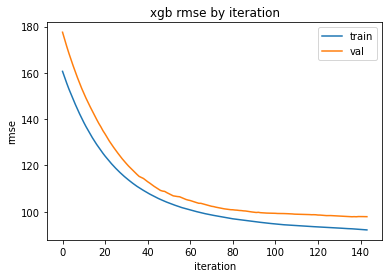

[0]	train-rmse:148.63724	val-rmse:149.57681
[1]	train-rmse:145.99071	val-rmse:146.88963
[2]	train-rmse:143.43886	val-rmse:144.37730
[3]	train-rmse:141.00297	val-rmse:141.93535
[4]	train-rmse:138.64546	val-rmse:139.59798
[5]	train-rmse:136.38888	val-rmse:137.40982
[6]	train-rmse:134.21666	val-rmse:135.31615
[7]	train-rmse:132.12315	val-rmse:133.54269
[8]	train-rmse:130.12540	val-rmse:131.67763
[9]	train-rmse:128.19656	val-rmse:129.99005
[10]	train-rmse:126.36676	val-rmse:128.31076
[11]	train-rmse:124.64436	val-rmse:126.76753
[12]	train-rmse:122.94259	val-rmse:125.29474
[13]	train-rmse:121.30406	val-rmse:123.90192
[14]	train-rmse:119.75042	val-rmse:122.31400
[15]	train-rmse:118.23965	val-rmse:121.03296
[16]	train-rmse:116.79004	val-rmse:119.66331
[17]	train-rmse:115.41386	val-rmse:118.41428
[18]	train-rmse:114.07368	val-rmse:117.35328
[19]	train-rmse:112.79156	val-rmse:116.30782
[20]	train-rmse:111.57061	val-rmse:115.28976
[21]	train-rmse:110.39802	val-rmse:114.31044
[22]	train-rmse:109.

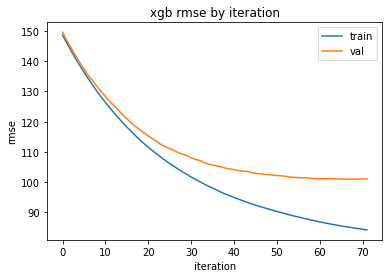

In [43]:

# model on all train data
xgb_model_artifacts = train_xgb_model(train)

# model on filtered data
xgb_model_artifacts_filtered = train_xgb_model(train_filtered)


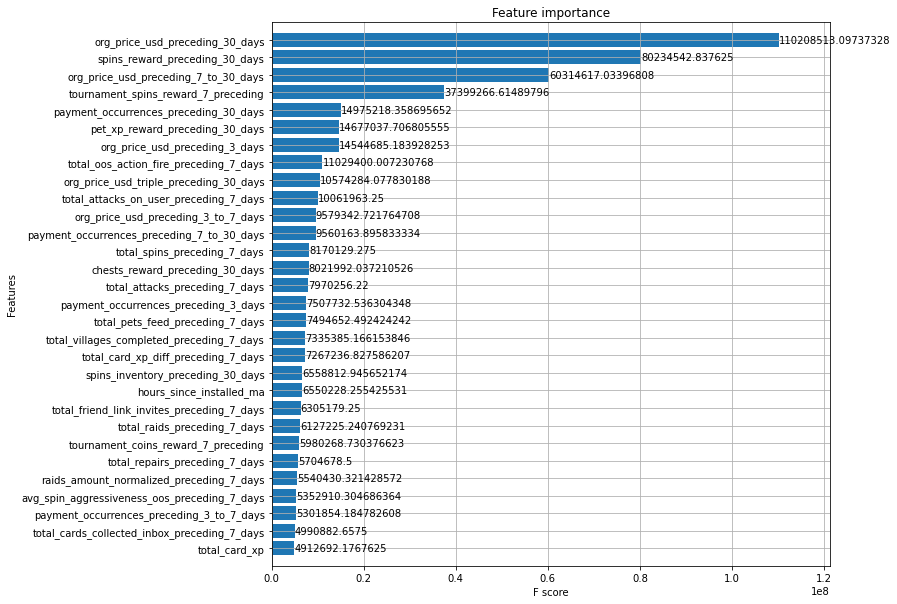

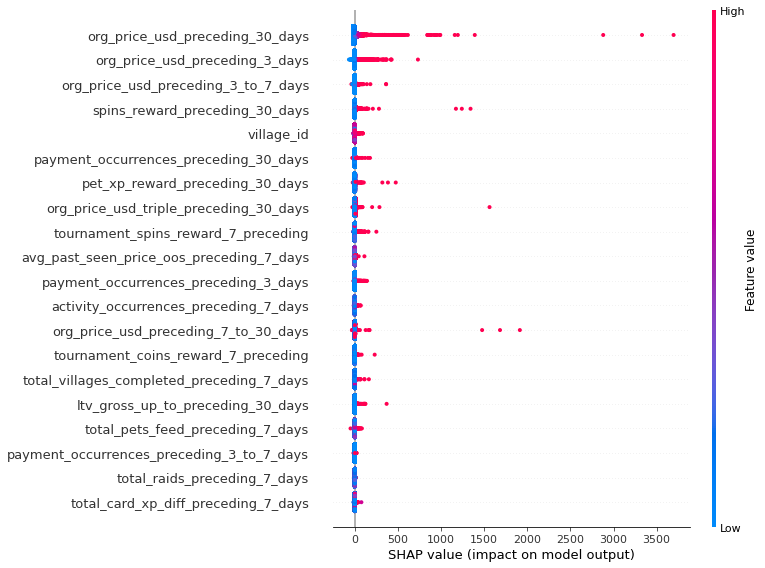

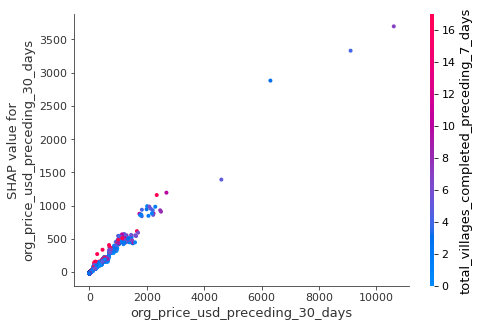

In [46]:
plot_importance_and_shaps(xgb_model_artifacts)

### looks like mostly positive relathionships (higher preceding spent means higher prediction etc) by shap on val

### as the red spots are mostly to the left and blue to the right, it looks like more villages completed means a stronger positive relathionship to the models output (steeper line)

# train lgbmcv

In [49]:
def train_lgb_cv(all_training_data: pd.DataFrame, label = TARGET_COL) -> List[float]:
    
    '''
    
    this function will train cross validated lgbm models, and return an average predicion on the test set
    
    '''
    
    features = all_training_data.columns.difference([label]).tolist()
    
    train_lgb = lgb.Dataset(data = all_training_data[features], label = all_training_data[label], feature_name = features)
    
    
    
    params = {'objective': 'regression'}

    nfolds = 5

    # train light gbm boosters cross validated
    cv_results = lgb.cv(
            params,
            train_lgb,
            num_boost_round=1500,
            nfold=nfolds,
            metrics='rmse',
            early_stopping_rounds=5,
            stratified=False,
            return_cvbooster =True
            )
    
    

    print(f"{len(cv_results['rmse-mean'])} rounds learned")

    lgbm_val_rmse = cv_results['rmse-mean'][-1]
    
    print("lgbm_val_rmse {}".format(lgbm_val_rmse))


    # predict on test
    
    lgbm_model =  cv_results["cvbooster"] 

    lgbm_test_prediction = lgbm_model.predict(test[features])

    lgbm_test_prediction_pd = pd.DataFrame(lgbm_test_prediction).T

    lgbm_test_prediction_pd["test_lgbm_predict"] = lgbm_test_prediction_pd.apply(np.mean,axis=1)

    
    return lgbm_test_prediction_pd["test_lgbm_predict"].tolist()

In [50]:
lgbm_test_prediction = train_lgb_cv(train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9134
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 52
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9134
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 52
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9134
[LightGBM] [Info] Numbe

# create a combnied test prediction

In [51]:
lgbm_test_prediction[0:5]

[6.047070227834858,
 238.4181504231279,
 24.602473168293628,
 12.146142024549377,
 58.44708079269431]

In [52]:
xgb_model_artifacts.preds_test[0:5]

[7.9732447, 233.28568, 24.924532, 10.904878, 56.567997]

In [53]:
xgb_model_artifacts_filtered.preds_test[0:5]

[7.737488, 225.19824, 21.580326, 11.104693, 45.998825]

In [54]:
def combine_and_write_test_prediction(preds : dict,
                                      test = test,
                                      dest = DESTINATION_PATH) -> pd.DataFrame:
    
    
    '''
    
    this function will average xgb and lgbm predictions, write it to destination path, and return the df.
    '''
    
    
    pred_cols = []
    
    for k,v in preds.items():
            
        test[k+"_pred"] = v
        
        pred_cols.append(k+"_pred")
    
    
    test["average_prediction"] = test[pred_cols].mean(axis=1)
    
    
    test.to_csv(f"{dest}\\test_with_pred.csv")
    
    return test

In [55]:
test_preds_dict = {"lgbm_cv":lgbm_test_prediction,
                  "xgb_all_data" : xgb_model_artifacts.preds_test,
                  "filtered_data" : xgb_model_artifacts_filtered.preds_test}


test_to_write = combine_and_write_test_prediction(test_preds_dict)

test_to_write.head()

,org_price_usd_following_30_days,payment_occurrences_preceding_30_days,hours_since_installed_ma,total_raids_preceding_7_days,org_price_usd_preceding_3_days,hours_in_village,total_card_xp,total_villages_completed_preceding_7_days,total_friends_active_in_the_last_7_to_14_days,chests_reward_preceding_30_days,...,spins_inventory_preceding_30_days,org_price_usd_preceding_3_to_7_days,total_set_completed,spins_reward_preceding_30_days,active_days_preceding_7_days,total_oos_action_fire,lgbm_cv_pred,xgb_all_data_pred,filtered_data_pred,average_prediction
0,0.00,1.0,33544.0,100.0,0.00,59.0,0.0,2.0,14.0,0.0,...,805.0,0.00,0.0,120.0,7.0,0.0,6.047070,7.973245,7.737488,7.252601
1,64.89,35.0,33542.0,26.0,62.94,44.0,0.0,2.0,7.0,10.0,...,44063.0,0.00,0.0,35395.0,7.0,0.0,238.418150,233.285675,225.198242,232.300689
2,4.99,4.0,33495.0,4.0,0.00,190.0,0.0,0.0,25.0,1.0,...,2053.0,0.00,0.0,1990.0,7.0,0.0,24.602473,24.924532,21.580326,23.702444
3,15.95,1.0,33349.0,19.0,3.99,60.0,0.0,4.0,0.0,0.0,...,221.0,0.00,0.0,220.0,7.0,0.0,12.146142,10.904878,11.104693,11.385238
4,61.91,11.0,33241.0,32.0,0.00,98.0,1975.0,1.0,24.0,3.0,...,4289.0,15.97,0.0,4190.0,7.0,0.0,58.447081,56.567997,45.998825,53.671301


# evaluation comparison

In [56]:
pred_columns = [c for c in test_to_write.columns if "pred" in c]

for c in pred_columns:
    
    print(c)
    print("rmse {}".format(np.sqrt(mean_squared_error(test_to_write[TARGET_COL],test_to_write[c]))))
    print("\n")

lgbm_cv_pred
rmse 103.94582323146128


xgb_all_data_pred
rmse 106.40160287863071


filtered_data_pred
rmse 107.95007514162569


average_prediction
rmse 102.9582453898516


